**Indirect reciprocity with charismatic individuals and reputation based interactions.**

After importing the libraries some auxiliary functions are coded that help the main simulation that can be found on "Simulation".
After that, some functions that analyse the data are done.
Finally, a lot of simulations are run to enable the formulation of hipotesis and conclusions.

**Libraries** : this cell should be the first one to be executed, because it imports all the needed libraries.


**Auxiliary functions** : a set of functions that were defined to simplify the writing of the code of the simulation and the posterior analysis of different simulations. Depends on : Libraries

**Simulation** : the function that processes the evolution of the network. This is the function that corresponds to the Algorithm 1. in the written part of the project. Depends on : Libraries; Auxiliary functions.

**Data analysis functions** : a set of functions with the goal of generating different simulations giving as output usefull plots and informations. This set of functions is responsable for the figures in the written part of the project. Depends on : Libraries, Auxiliary functions, Simulation.

The other sections in the python's notebook are dedicated to the actual simulations. These simulations were grouped in sections named accordingly to what is being studied. 



In [ ]:
import networkx as nx
import random #as R
import numpy as np
import math
import matplotlib.pyplot as plt
from time import time
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap 

# Auxiliary functions

In [ ]:
#Output : cria lista apenas com os atributos (ordenados por nós) do grafo G
def selecionar_atributo(G,atributo):
    return [i for (n,i) in list(G.nodes(data=atributo))]

In [ ]:
#selecionar_atributo(G,'reputacao')

In [ ]:
#Output da funcao corresponde a uma lista de pares de listas (nó, valor do atributo para esse nó)
#n : numero de nós
#inf,sup : valores minimo e máximo que o atributo pode ter, respetivemente
#balance : valor entre 0 e 1, que caracteriza o equilibrio dos valores dos atributos
### Exemplo : balance = 0.5 => os valores dos atributos vão estar igualemente distribuídos
### Exemplo : balance = 0.2 => 20% dos nós tem valore de atributos em [inf,valor_medio(inf,sup)], os outros 80% em [valor_medio,sup]

def def_atributo(balance,n,inf,sup):
    atributo_aleatorio = [random.uniform(inf,(sup-abs(inf))/2) for i in range(math.floor(n*balance)) ] + [random.uniform((sup-abs(inf))/2,sup) for i in range(math.floor(n*balance),n) ]
    random.shuffle(atributo_aleatorio)
    return [(i,atributo_aleatorio[i]) for i in range(n)]

In [ ]:
def_atributo(0.5,10,0,1)

[(0, 0.1863586926678743),
 (1, 0.20259473576336418),
 (2, 0.007346739073516684),
 (3, 0.87193164261826),
 (4, 0.9253213527330322),
 (5, 0.5793633021619231),
 (6, 0.20181900496203187),
 (7, 0.4945725409599846),
 (8, 0.9481227796083852),
 (9, 0.7457465534647841)]

In [ ]:
# Funcao que escolhe o vizinho para interagir com base nas reputacoes dos mesmos
# no : numero de nó que esta a agir
# vizinhos : lista de vizinhos deste nó
# reputacoes : lista com as reputacoes de todos os nós --- usar funcao selecionar_atributo

def escolher_vizinho(no,vizinhos,reputacoes,cena_da_reputacao):
    if not cena_da_reputacao:
        return random.choice(vizinhos)
    else:
        #seleciona as reputacoes dos vizinhos do no e deteta o seu minimo
        reputacoes_vizinhos = np.array([reputacoes[i] for i in vizinhos])
        minimo_reputacoes_vizinhos = min(reputacoes_vizinhos)
        
        #se alguma das reputacoes for não positiva é necessário torná-las positivas para calcular a régua
        #vamos dar um shift igual a todas as reputacoes, de modo à reputacao minima ser = 1
        if minimo_reputacoes_vizinhos<=0:
            reputacoes_vizinhos += (-minimo_reputacoes_vizinhos + 1)*np.ones(len(reputacoes_vizinhos)) #adoro
        
        #fazer a regua
        reputacao_cumulativa_vizinhos = np.cumsum(reputacoes_vizinhos)        #Ex : [1,4,3]-->[1,5,8]
        
        #selecionar vizinho
        aleatorio = random.uniform(0, reputacao_cumulativa_vizinhos[-1])      #Este numero aleatorio inicio em zero para dar alguma chance ao pior reputada
        
        k=0
        for i in reputacao_cumulativa_vizinhos: 
            if aleatorio <= i :
                return vizinhos[k] 
            k+=1

In [ ]:
# Funcao que seleciona as acoes de cooperacao do nó e do vizinho:
# TRUE : cooperar
# FALSE : não cooperar
# EX: (TRUE,FALSE)-->nó coopera, vizinho não coopera
# EX: (FALSE,TRUE)-->nó não coopera, vizinho coopera
# EX: (TRUE,TRUE)-->nó coopera, vizinho coopera
# EX: (FALSE,FALSE)-->nó não coopera, vizinho não coopera

def escolher_acoes(no,vizinho,honestidades):
    aleatorio_no = random.uniform(0,1)
    aleatorio_vizinho = random.uniform(0,1)
    
    if aleatorio_no <= honestidades[no]:
        acao_no = True
    else:
        acao_no = False
        
    if aleatorio_vizinho <= honestidades[vizinho]:
        acao_vizinho = True
    else:
        acao_vizinho = False
        
    return (acao_no, acao_vizinho)

In [ ]:
# Funcao que atualiza o grafo G consoante o update no dinheiro
#(R,T,S,P) : jogo implementado
#no : indice no nó que está a ter a iniciativa
#vizinho : indice do outro nó presente na interação
#acao_no : valor bolleano para a acao do no (TRUE : cooperar, FALSE: não cooperar)
#acao_vizinho : valor bolleano para a acao do vizinho (TRUE : cooperar, FALSE: não cooperar)
#G : grafo

def update_dinheiro(R,T,S,P,no,vizinho,acao_no,acao_vizinho,G):
    
    if acao_no and acao_vizinho:
        novo_dinheiro_no = G.nodes[no]['dinheiro'] + R
        novo_dinheiro_vizinho = G.nodes[vizinho]['dinheiro'] + R
    elif acao_no and not acao_vizinho:
        novo_dinheiro_no = G.nodes[no]['dinheiro'] + S
        novo_dinheiro_vizinho = G.nodes[vizinho]['dinheiro'] + T
    elif not acao_no and acao_vizinho:
        novo_dinheiro_no = G.nodes[no]['dinheiro'] + T
        novo_dinheiro_vizinho = G.nodes[vizinho]['dinheiro'] + S
    else:
        novo_dinheiro_no = G.nodes[no]['dinheiro'] + P
        novo_dinheiro_vizinho = G.nodes[vizinho]['dinheiro'] + P
        
    nx.set_node_attributes(G,dict([(no,novo_dinheiro_no)]) , 'dinheiro')
    nx.set_node_attributes(G,dict([(vizinho,novo_dinheiro_vizinho)]) , 'dinheiro')
    
    return G

In [ ]:
# Funcao que atualiza o grafo G consoante o update das reputações
#CM1,CM2,CM3,CM4 código moral.
#no : indice no nó que está a ter a iniciativa
#vizinho : indice do outro nó presente na interação
#acao_no : valor bolleano para a acao do no (TRUE : cooperar, FALSE: não cooperar)
#acao_vizinho : valor bolleano para a acao do vizinho (TRUE : cooperar, FALSE: não cooperar)
#G : grafo

def update_reputacao(CM1,CM2,CM3,CM4,no,vizinho,acao_no,acao_vizinho,G):
    carisma_no = G.nodes[no]['carisma']
    carisma_vizinho = G.nodes[vizinho]['carisma']

    reputacao_no = G.nodes[no]['reputacao']
    reputacao_vizinho = G.nodes[vizinho]['reputacao']

    #update à reputacão do no:
    
    if acao_no and reputacao_vizinho >= 0:
        if CM1 < 0: #fazemos isto nos casos em que o código moral diz que ele vai diminuir de reputação, nesse caso a nova reputaçao dele muda a multiplicar por 1-carisma
            carisma_no = 1-carisma_no
        novo_reputacao_no = reputacao_no + CM1*carisma_no
    elif acao_no and not reputacao_vizinho >= 0:
        if CM3 < 0: 
            carisma_no = 1-carisma_no
        novo_reputacao_no = reputacao_no + CM3*carisma_no
    elif not acao_no and reputacao_vizinho >= 0:
        if CM2 < 0: 
            carisma_no = 1-carisma_no
        novo_reputacao_no = reputacao_no + CM2*carisma_no
    else:
        if CM4 < 0: 
            carisma_no = 1-carisma_no
        novo_reputacao_no = reputacao_no + CM4*carisma_no

    #agora atualizamos a reputacao do vizinho:

    if acao_vizinho and reputacao_no >= 0:
        if CM1 < 0: 
            carisma_vizinho = 1-carisma_vizinho
        novo_reputacao_vizinho = reputacao_vizinho + CM1*carisma_vizinho
    elif acao_vizinho and not reputacao_no >= 0:
        if CM3 < 0: 
            carisma_vizinho = 1-carisma_vizinho
        novo_reputacao_vizinho = reputacao_vizinho + CM3*carisma_vizinho
    elif not acao_vizinho and reputacao_no >= 0:
        if CM2 < 0: 
            carisma_vizinho = 1-carisma_vizinho
        novo_reputacao_vizinho = reputacao_vizinho + CM2*carisma_vizinho
    else:
        if CM4 < 0: 
            carisma_vizinho = 1-carisma_vizinho
        novo_reputacao_vizinho = reputacao_vizinho + CM4*carisma_vizinho
        
    nx.set_node_attributes(G,dict([(no,novo_reputacao_no)]) , 'reputacao')
    nx.set_node_attributes(G,dict([(vizinho,novo_reputacao_vizinho)]) , 'reputacao')
    
    return G

In [ ]:
# Funcao que se destina a devolver um grafo, modificando os atributos do seu nó de maior grau
# Esta função devolve ainda o indice nesse nó - hub

def modificar_hub(G,novo_carisma,nova_honestidade,nova_reputacao):
    #Encontrar hub
    hub_degree = max([G.degree(j) for j in G.nodes()])
    hub = [i for i in G.nodes() if G.degree(i) == hub_degree][0]
    
    #Alterar atributos do hub
    G.nodes[hub]['carisma'] = novo_carisma
    G.nodes[hub]['honestidade'] = nova_honestidade
    G.nodes[hub]['reputacao'] = nova_reputacao
    
    return G,hub

In [ ]:
# Funcao que se destina a devolver um grafo, modificando os atributos do seu nó de maior grau
# Esta função devolve ainda o indice nesse nó - hub
# alpha entre 0 e 1
def modificar_hubs(G,alpha,novo_carisma,nova_honestidade,nova_reputacao):
    #Encontrar hubs
    hub_degree = max([G.degree(j) for j in G.nodes()])
    hubs = [i for i in G.nodes() if G.degree(i) >= alpha*hub_degree]
    #print([G.degree(j) for j in hubs])
    
    #Alterar atributos do hub
    for i in hubs:
        G.nodes[i]['carisma'] = novo_carisma
        G.nodes[i]['honestidade'] = nova_honestidade
        G.nodes[i]['reputacao'] = nova_reputacao
    
    return G,hubs

In [ ]:
def cria_barabasi_graph(n,med_carisma=0.5,med_honestidade=0.5,med_reputacao=0):
    carisma_inicial = def_atributo(med_carisma,n,0,1)
    honestidade_inicial = def_atributo(med_honestidade,n,0,1)
    reputacao_inicial = def_atributo(med_reputacao,n,-1,1)
    numero_interacoes = def_atributo(0.5,n,0,0)
    dinheiro = def_atributo(0.5,n,0,0)

    A = nx.barabasi_albert_graph(n,3)
    #Associação dos atributos à rede
    nx.set_node_attributes(A,dict(carisma_inicial) , 'carisma')
    nx.set_node_attributes(A,dict(honestidade_inicial) , 'honestidade')
    nx.set_node_attributes(A,dict(reputacao_inicial) , 'reputacao')
    nx.set_node_attributes(A,dict(numero_interacoes) , 'numero_interacoes')
    nx.set_node_attributes(A,dict(dinheiro) , 'dinheiro')
    
    return A

# Simulation

In [ ]:
#Introduzir grafo G

def evolucao(G,t,R=2,T=3,S=-1,P=0,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1, cena_da_reputacao = True):
    start = time()

    #dilema do prisioneiro:
    #R,T,S,P = (2,3,-1,0)

    #stag or hare:
    #R,T,S,P = (3,1,1,2)

    #snowdrift/chicken game:
    #R,T,S,P = (2,3,1,0)

    #heaven
    #R,T,S,P = (3,2,0,-1)

    #definimos aqui o código moral
    #CM1 significa cooperar com alguem com boa reputação
    #CM2 significa nao cooperar com alguem com boa reputação
    #CM3 significa cooperar com alguem com má reputação
    #CM4 significa não cooperar com alguem com má reputação 

    #1 significa que é bem visto, -1 significa que é mal visto,
    #até poderiamos potencialmente aumentar alguns valores

    #este é o código moral de ordem 1 em que cooperar é bem visto e nao cooperar é mal visto
    #CM1,CM2,CM3,CM4 = (1,-1,1,-1)

    #este é o código moral de ordem 2 em que cooperar com bons é bem visto e nao cooperar com maus é bem visto
    #CM1,CM2,CM3,CM4 = (1,-1,-1,1)

    #este é o código moral de ordem 2 em que interagir com bons é bem visto e interagir com maus é mal visto
    #CM1,CM2,CM3,CM4 = (1,1,-1,-1)

    #este é o código moral de ordem 2 em que cooperar com bons é bem visto e e o resto é tudo mal visto
    #CM1,CM2,CM3,CM4 = (1,-1,-1,-1)

    
    carismas = selecionar_atributo(G,'carisma') 
    honestidades = selecionar_atributo(G,'honestidade')


    #criar aqui variáveis que nos permitam ver a evolução das coisas ao longo do tempo
    #estas variaveis vao acabar por ser uma matriz com t linhas e len(G.nodes) colunas
    #em que em cada coluna tem cada no, cada linha é uma iteraçao,
    #conseguimos ter toda a informaçao da rede a evoluir no tempo
    evolucao_do_dinheiro =  [] #selecionar_atributo(G,'dinheiro') 
    evolucao_da_reputacao = [] #selecionar_atributo(G,'reputacao') 
    evolucao_do_numero_interacoes = []

    #estas variaveis sao listas com t de comprimento, que simbolizam um atribulo global d rede a evoluir no tempo
    evolucao_dinheiro_global = []
    
    #Numero de iteracoes
    for i in range(t):
        #Cada iteracao percorre todos os nós de G
        tempo_de_cada_iteraçao_start = time()
        for i in G.nodes():
            dinheiros = selecionar_atributo(G,'dinheiro') #Lista ordenada com dinheiros do grafo
            reputacoes = selecionar_atributo(G,'reputacao') #Lista ordenada com reputacoes do grafo
            
            vizinhos = list(G.neighbors(i))
            
            #Selecionar vizinho para interagir
            vizinho_escolhido = escolher_vizinho(i,vizinhos,reputacoes,cena_da_reputacao)
            
            #Selecionar acões de cooperacao para nó i e nó vizinho
            (acao_no, acao_vizinho) = escolher_acoes(i,vizinho_escolhido,honestidades)
            
            #Dar update no grafo (alterando o dinheiro) consoante as ações escolhidas e o jogo em causa
            G = update_dinheiro(R,T,S,P,i,vizinho_escolhido,acao_no,acao_vizinho,G)
            
            G = update_reputacao(CM1,CM2,CM3,CM4,i,vizinho_escolhido,acao_no,acao_vizinho,G)

            #dar update ao numero de interaçoes:
            nx.set_node_attributes(G,dict([(i, G.nodes[i]['numero_interacoes']+1 )]) , 'numero_interacoes')
            nx.set_node_attributes(G,dict([(vizinho_escolhido, G.nodes[vizinho_escolhido]['numero_interacoes']+1 )]) , 'numero_interacoes')

        evolucao_do_dinheiro +=  [ selecionar_atributo(G,'dinheiro')   ] 
        evolucao_da_reputacao += [ selecionar_atributo(G,'reputacao')  ] 
        evolucao_do_numero_interacoes += [ selecionar_atributo(G,'numero_interacoes') ]

        #estas variaveis sao listas com t de comprimento, que simbolizam um atribulo global da rede a evoluir no tempo
        evolucao_dinheiro_global += [ np.sum(selecionar_atributo(G,'dinheiro')) ]

        #print(time() - tempo_de_cada_iteraçao_start)

    #print("tempo de execução" + str(time()-start))

    return evolucao_do_dinheiro, evolucao_da_reputacao, evolucao_do_numero_interacoes, evolucao_dinheiro_global
            

# Data analysis - functions

In [ ]:
def analise(G,evolucao_do_dinheiro, evolucao_da_reputacao, evolucao_do_numero_interacoes, evolucao_dinheiro_global):
    start = time()
    carismas = selecionar_atributo(G,'carisma') 
    honestidades = selecionar_atributo(G,'honestidade')

    

    t = len(evolucao_do_dinheiro)
    n = len(G.nodes)

    carisma_media = sum(carismas)/n
    honestidade_media = sum(honestidades)/n

    print("carisma_media: " + str(carisma_media) )
    print("honestidade_media: " + str(honestidade_media))

    #aqui vamos calcular a evoluçao de quanto dinheiro foi formado na comunidade toda
    evoluçao_dinheiro_ganho_em_cada_iteracao = [ evolucao_dinheiro_global[0] ]
    for i in range(t-1):
      evoluçao_dinheiro_ganho_em_cada_iteracao += [ evolucao_dinheiro_global[i+1] - evolucao_dinheiro_global[i] ]

    plt.subplot(2,2,1)
    
    
    plt.plot(range(t),evoluçao_dinheiro_ganho_em_cada_iteracao)

    #aqui vamos calcular a evoluçao da reputação média da comunidade:
    evoluçao_reputacao_media = [  ]
    for i in range(t):
      evoluçao_reputacao_media += [ np.sum( evolucao_da_reputacao[i] )/n ]
    
    plt.subplot(2,2,2)
    
    plt.plot(range(t),evoluçao_reputacao_media)

    #vamos aqui buscar a maior hub:
    hub_1 = [i for i in G.nodes() if G.degree(i) == max([G.degree(j) for j in G.nodes()]) ][0]
    print("carisma da hub: " + str(G.nodes[hub_1]["carisma"]))
    print("honestidade da hub: " + str(G.nodes[hub_1]["honestidade"]))
    print("grau da hub: " + str(G.degree(hub_1)))

    plt.subplot(2,2,3)
    #ver a evolução de dinheiro da hub
    plt.plot(range(t),[i[hub_1] for i in evolucao_do_dinheiro ])
    plt.subplot(2,2,4)
    #ver a evolução da reputaçao da hub
    plt.plot(range(t),[i[hub_1] for i in evolucao_da_reputacao ])

    plt.show()
    
    start_tensor = time()
    #agora vamos fazer uma análise de quanto "dinheiro" ganharam, em média, as pessoas com 
    #carisma     no intervalo [l*i,l*(i+1)] i=0,...,((1/l)-1) e
    #honestidade no intervalo [l*i,l*(i+1)] i=0,...,((1/l)-1)  1/l tem que ser inteiro
    #l = 0.05
    l = 0.1
    #l = 0.2
    #l = 0.25
    #l = 0.5
    intervalos = [0] + [0+l*(i+1) for i in range(int(1/l))]

    #este ciclo faz uma matriz quadrada com "o numero de intervalos" linhas.
    #em cada entrada ij da matriz, estão os nós que teem carisma i e honestidade j
    #"nós com carisma i" significa com carisma entre i*l e (i+1)*l
    #print(intervalos)
    nos_na_grelha = [ [  [] for i in range(len(intervalos)-1) ] for j in range(len(intervalos)-1) ]
    #print(len(nos_na_grelha))
    #print(len(nos_na_grelha[0]))
    for i in range(len(intervalos)-1):
        for j in range(len(intervalos)-1):
           for z in G.nodes():
                if intervalos[i] <= G.nodes[z]["carisma"] < intervalos[i+1] and intervalos[j] <= G.nodes[z]["honestidade"] < intervalos[j+1]:
                    nos_na_grelha[i][j].append(z)

    #print(nos_na_grelha)       

    #agora vamos fazer um tensor que é uma lista em que cada elemento é uma matriz:
    #cada lista representa a iteraçao t,
    #em cada iteraçao, vamos ter uma matriz cuja entrada ij representa o dinheiro médio ganho por pessoas
    #com carisma i e honestidade j
    #um tensor é o nome da generalizaçao de matriz. tal como uma matriz é um vetor de vetores...
    #um tensor é um vetor de matrizes basicamente
    #podiamos so fazer a matriz no tempo final... mas ja agora tb fazemos a evoluçao no tempo
    tensor_dinheiro = []
    for z in range(t):
        matriz_dinheiro = [ [0 for i in range(len(nos_na_grelha))] for j in range(len(nos_na_grelha)) ]

        #vamos fazer a matriz ij para o tempo z, a entrada ij tem
        #"a média do dinheiro no tempo z de pessoas com carisma i e honestidade j"
        for i in range(len(nos_na_grelha)):
            for j in range(len(nos_na_grelha[i])): 
                dinheiros = [ G.nodes[w]["dinheiro"] for w in nos_na_grelha[i][j]  ]
                if len(dinheiros) == 0:
                    matriz_dinheiro[i][j] = 0
                else:
                    matriz_dinheiro[i][j] = sum(dinheiros)/len(dinheiros)
        
        tensor_dinheiro += [ matriz_dinheiro ]

    #print(tensor_dinheiro)

    #repetir o mesmo para a reputaçao:

    tensor_reputacao = []
    for z in range(t):
        matriz_reputacao = [ [0 for i in range(len(nos_na_grelha))] for j in range(len(nos_na_grelha)) ]

        #vamos fazer a matriz ij para o tempo z, a entrada ij tem
        #"a média do dinheiro no tempo z de pessoas com carisma i e honestidade j"
        for i in range(len(nos_na_grelha)):
            for j in range(len(nos_na_grelha[i])): 
                reputacoes = [ G.nodes[w]["reputacao"] for w in nos_na_grelha[i][j]  ]
                if len(reputacoes) == 0:
                    matriz_reputacao[i][j] = 0
                else:
                    matriz_reputacao[i][j] = sum(reputacoes)/len(reputacoes)
        
        tensor_reputacao += [ matriz_reputacao ]

    #print(tensor_dinheiro)


    plasma = cm.get_cmap('plasma', 256)
    print(tensor_dinheiro[-1])
    fig, (ax0,ax1) =  plt.subplots(1, 2,  figsize=(6, 3), constrained_layout=True)

    psm0 = ax0.pcolormesh(tensor_dinheiro[-1], cmap=plasma  , rasterized=True, vmin=min( [min(i) for i in tensor_dinheiro[-1] ]), vmax=max( [max(i) for i in tensor_dinheiro[-1] ]))

    #plt.xlabel("honestidade")
    #plt.ylabel("carisma")
    ax0.set_title('Dinheiro')
    fig.colorbar(psm0,ax = ax0)


    #fig1, (ax1,ax2) =  plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    #fig = plt.figure()
    #for [ax, cmap] in zip(axs, [plasma]):
    psm1 = ax1.pcolormesh(tensor_reputacao[-1], cmap=plasma  , rasterized=True, vmin=min( [min(i) for i in tensor_reputacao[-1] ]), vmax=max( [max(i) for i in tensor_reputacao[-1] ]))
    fig.colorbar(psm1,ax = ax1)
    ax1.set_title('reputação')

    plt.setp([ax0,ax1], xlabel='Honesty')
    plt.setp([ax0,ax1], ylabel='Charisma')


    plt.show()




    #tentar fazer o gif:
    #fig, ax = plt.subplots()  
    #x, ysin, ycos = [], [], []  
    #ln1, = plt.plot([], [], 'ro')  
    #ln2, = plt.plot([], [], 'm*')  

    #def init():  
    #    ax.set_xlim(0, 2*np.pi)  
    #    ax.set_ylim(-1, 1)  
      
    #def update(i):  
    #    x.append(i)  
    #    ysin.append(np.sin(i))  
    #    ycos.append(np.cos(i))  
    #    ln1.set_data(x, ysin)  
    #    ln2.set_data(x, ycos) 
    #se quisermos gravar o gif é tirar estes comentarios:
    #writer = PillowWriter(fps=25)  
    #ani.save("demo_sine.gif", writer=writer)  
    #ani = FuncAnimation(fig, update, np.linspace(0, 2*np.pi, 64), init_func=init)  
    #plt.show()

    print("tempo de fazer o tensor: " + str(time()-start_tensor))
    print("tempo de analise" + str(time() - start))

In [ ]:
def analise_grande(numero_de_simulaçoes,n,t, tipo_de_simulaçao = 1,R=2,T=3,S=-1,P=0,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1,med_carisma=0.5,med_honestidade=0.5,med_reputacao=0,cena_da_reputacao = True):
    start = time()
    
    for it in range(numero_de_simulaçoes):
        if it == 0:
            start_simulaçao = time()
        
        if tipo_de_simulaçao == 1:
            G = cria_barabasi_graph(n,med_carisma,med_honestidade,med_reputacao)
        elif tipo_de_simulaçao == 2:
            pass
            #fazer um random graph
        a,b,c,d = evolucao(G,t,R,T,S,P,CM1,CM2,CM3,CM4,cena_da_reputacao)


        carismas = selecionar_atributo(G,'carisma') 
        honestidades = selecionar_atributo(G,'honestidade')

        if it==0:
            carisma_media = sum(carismas)/len(carismas)
            honestidade_media = sum(honestidades)/len(carismas)

            print("carisma_media: " + str(carisma_media) )
            print("honestidade_media: " + str(honestidade_media))


        #l = 0.05
        l = 0.1
        #l = 0.2
        #l = 0.25
        #l = 0.5
        intervalos = [0] + [0+l*(i+1) for i in range(int(1/l))]

        #este ciclo faz uma matriz quadrada com "o numero de intervalos" linhas.
        #em cada entrada ij da matriz, estão os nós que teem carisma i e honestidade j
        #"nós com carisma i" significa com carisma entre i*l e (i+1)*l
        #print(intervalos)
        nos_na_grelha = [ [  [] for i in range(len(intervalos)-1) ] for j in range(len(intervalos)-1) ]
        #print(len(nos_na_grelha))
        #print(len(nos_na_grelha[0]))
        for i in range(len(intervalos)-1):
            for j in range(len(intervalos)-1):
                for z in G.nodes():
                    if intervalos[i] <= G.nodes[z]["carisma"] < intervalos[i+1] and intervalos[j] <= G.nodes[z]["honestidade"] < intervalos[j+1]:
                        nos_na_grelha[i][j].append(z)

        #print(nos_na_grelha)       

        #agora vamos fazer um tensor que é uma lista em que cada elemento é uma matriz:
        #cada lista representa a iteraçao t,
        #em cada iteraçao, vamos ter uma matriz cuja entrada ij representa o dinheiro médio ganho por pessoas
        #com carisma i e honestidade j
        #um tensor é o nome da generalizaçao de matriz. tal como uma matriz é um vetor de vetores...
        #um tensor é um vetor de matrizes basicamente
        #podiamos so fazer a matriz no tempo final... mas ja agora tb fazemos a evoluçao no tempo
        tensor_dinheiro = []
        for z in range(t):
            matriz_dinheiro = [ [0 for i in range(len(nos_na_grelha))] for j in range(len(nos_na_grelha)) ]

            #vamos fazer a matriz ij para o tempo z, a entrada ij tem
            #"a média do dinheiro no tempo z de pessoas com carisma i e honestidade j"
            for i in range(len(nos_na_grelha)):
                for j in range(len(nos_na_grelha[i])): 
                    dinheiros = [ G.nodes[w]["dinheiro"] for w in nos_na_grelha[i][j]  ]
                    if len(dinheiros) == 0:
                        matriz_dinheiro[i][j] = 0
                    else:
                        matriz_dinheiro[i][j] = sum(dinheiros)/len(dinheiros)
            
            tensor_dinheiro += [ matriz_dinheiro ]

        #print(tensor_dinheiro)

        #repetir o mesmo para a reputaçao:

        tensor_reputacao = []
        for z in range(t):
        
            matriz_reputacao = [ [0 for i in range(len(nos_na_grelha))] for j in range(len(nos_na_grelha)) ]

            #vamos fazer a matriz ij para o tempo z, a entrada ij tem
            #"a média do dinheiro no tempo z de pessoas com carisma i e honestidade j"
            for i in range(len(nos_na_grelha)):
                for j in range(len(nos_na_grelha[i])): 
                    reputacoes = [ G.nodes[w]["reputacao"] for w in nos_na_grelha[i][j]  ]
                    if len(reputacoes) == 0:
                        matriz_reputacao[i][j] = 0
                    else:
                        matriz_reputacao[i][j] = sum(reputacoes)/len(reputacoes)
            
            tensor_reputacao += [ matriz_reputacao ]
            

        if it == 0:
            tensor_soma_dinheiro  = tensor_dinheiro
            tensor_soma_reputacao = tensor_reputacao
            print("tempo da primeira simulaçao: " + str(time()-start_simulaçao) )
        else:
            for j in range(len(tensor_dinheiro)):
                for z in range(len(tensor_dinheiro[j])):
                    for w in range(len(tensor_dinheiro[j][z])):
                        tensor_soma_dinheiro[j][z][w]  +=  tensor_dinheiro[j][z][w]
                        tensor_soma_reputacao[j][z][w] += tensor_reputacao[j][z][w]


    #agora temos que fazer a média para os tensores_soma:
    for j in range(len(tensor_dinheiro)):
        for z in range(len(tensor_dinheiro[j])):
            for w in range(len(tensor_dinheiro[j][z])):
                tensor_soma_dinheiro[j][z][w]  =  tensor_soma_dinheiro[j][z][w] / numero_de_simulaçoes
                tensor_soma_reputacao[j][z][w] = tensor_soma_reputacao[j][z][w] / numero_de_simulaçoes
    plasma = cm.get_cmap('plasma', 256)
    fig, (ax0,ax1) =  plt.subplots(1, 2,  figsize=(6, 3), constrained_layout=True)
    psm0 = ax0.pcolormesh(tensor_soma_dinheiro[-1], cmap=plasma  , rasterized=True, vmin=min( [min(i) for i in tensor_soma_dinheiro[-1] ]), vmax=max( [max(i) for i in tensor_soma_dinheiro[-1] ]))
    ax0.set_title('Dinheiro')
    fig.colorbar(psm0,ax = ax0)


    #fig1, (ax1,ax2) =  plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    #fig = plt.figure()
    #for [ax, cmap] in zip(axs, [plasma]):
    psm1 = ax1.pcolormesh(tensor_soma_reputacao[-1], cmap=plasma  , rasterized=True, vmin=min( [min(i) for i in tensor_soma_reputacao[-1] ]), vmax=max( [max(i) for i in tensor_soma_reputacao[-1] ]))
    fig.colorbar(psm1,ax = ax1)
    ax1.set_title('reputação')

    plt.setp([ax0,ax1], xlabel='Honesty')
    plt.setp([ax0,ax1], ylabel='Charisma')


    plt.show()
    print("tempo de analise" + str(time() - start))

In [ ]:
def analise_hub(numero_de_simulaçoes,n,t, tipo_de_simulaçao = 1,R=2,T=3,S=-1,P=0,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1,med_carisma=0.5,med_honestidade=0.5,med_reputacao=0,cena_da_reputacao = True,novo_carisma=1,nova_honestidade=1,nova_reputacao=1):
    start = time()
    
    for it in range(numero_de_simulaçoes):
        if it == 0:
            start_simulaçao = time()
        
        if tipo_de_simulaçao == 1:
            G = cria_barabasi_graph(n,med_carisma,med_honestidade,med_reputacao)
            G, hub = modificar_hub(G,novo_carisma,nova_honestidade,nova_reputacao)
        elif tipo_de_simulaçao == 2:
            pass
            #fazer um random graph
        a,b,c,d = evolucao(G,t,R,T,S,P,CM1,CM2,CM3,CM4,cena_da_reputacao)


        carismas = selecionar_atributo(G,'carisma') 
        honestidades = selecionar_atributo(G,'honestidade')

        if it==0:
            carisma_media = sum(carismas)/len(carismas)
            honestidade_media = sum(honestidades)/len(carismas)

            print("carisma_media: " + str(carisma_media) )
            print("honestidade_media: " + str(honestidade_media))


        #l = 0.05
        l = 0.1
        #l = 0.2
        #l = 0.25
        #l = 0.5
        intervalos = [0] + [0+l*(i+1) for i in range(int(1/l))]

        #este ciclo faz uma matriz quadrada com "o numero de intervalos" linhas.
        #em cada entrada ij da matriz, estão os nós que teem carisma i e honestidade j
        #"nós com carisma i" significa com carisma entre i*l e (i+1)*l
        #print(intervalos)
        nos_na_grelha = [ [  [] for i in range(len(intervalos)-1) ] for j in range(len(intervalos)-1) ]
        #print(len(nos_na_grelha))
        #print(len(nos_na_grelha[0]))
        for i in range(len(intervalos)-1):
            for j in range(len(intervalos)-1):
                for z in G.nodes():
                    if intervalos[i] <= G.nodes[z]["carisma"] < intervalos[i+1] and intervalos[j] <= G.nodes[z]["honestidade"] < intervalos[j+1]:
                        nos_na_grelha[i][j].append(z)

        #print(nos_na_grelha)       

        #agora vamos fazer um tensor que é uma lista em que cada elemento é uma matriz:
        #cada lista representa a iteraçao t,
        #em cada iteraçao, vamos ter uma matriz cuja entrada ij representa o dinheiro médio ganho por pessoas
        #com carisma i e honestidade j
        #um tensor é o nome da generalizaçao de matriz. tal como uma matriz é um vetor de vetores...
        #um tensor é um vetor de matrizes basicamente
        #podiamos so fazer a matriz no tempo final... mas ja agora tb fazemos a evoluçao no tempo
        tensor_dinheiro = []
        for z in range(t):
            matriz_dinheiro = [ [0 for i in range(len(nos_na_grelha))] for j in range(len(nos_na_grelha)) ]

            #vamos fazer a matriz ij para o tempo z, a entrada ij tem
            #"a média do dinheiro no tempo z de pessoas com carisma i e honestidade j"
            for i in range(len(nos_na_grelha)):
                for j in range(len(nos_na_grelha[i])): 
                    dinheiros = [ G.nodes[w]["dinheiro"] for w in nos_na_grelha[i][j]  ]
                    if len(dinheiros) == 0:
                        matriz_dinheiro[i][j] = 0
                    else:
                        matriz_dinheiro[i][j] = sum(dinheiros)/len(dinheiros)
            
            tensor_dinheiro += [ matriz_dinheiro ]

        #print(tensor_dinheiro)

        #repetir o mesmo para a reputaçao:

        tensor_reputacao = []
        for z in range(t):
        
            matriz_reputacao = [ [0 for i in range(len(nos_na_grelha))] for j in range(len(nos_na_grelha)) ]

            #vamos fazer a matriz ij para o tempo z, a entrada ij tem
            #"a média do dinheiro no tempo z de pessoas com carisma i e honestidade j"
            for i in range(len(nos_na_grelha)):
                for j in range(len(nos_na_grelha[i])): 
                    reputacoes = [ G.nodes[w]["reputacao"] for w in nos_na_grelha[i][j]  ]
                    if len(reputacoes) == 0:
                        matriz_reputacao[i][j] = 0
                    else:
                        matriz_reputacao[i][j] = sum(reputacoes)/len(reputacoes)
            
            tensor_reputacao += [ matriz_reputacao ]
            

        if it == 0:
            tensor_soma_dinheiro  = tensor_dinheiro
            tensor_soma_reputacao = tensor_reputacao
            print("tempo da primeira simulaçao: " + str(time()-start_simulaçao) )
        else:
            for j in range(len(tensor_dinheiro)):
                for z in range(len(tensor_dinheiro[j])):
                    for w in range(len(tensor_dinheiro[j][z])):
                        tensor_soma_dinheiro[j][z][w]  +=  tensor_dinheiro[j][z][w]
                        tensor_soma_reputacao[j][z][w] += tensor_reputacao[j][z][w]
        

        dinheiros = selecionar_atributo(G,'dinheiro') 
        interacoes = selecionar_atributo(G,'numero_interacoes')
        if it == 0:
          dinheiro_medio_acum = 0
          interacao_hub_percentagem_acum = 0
        dinheiro_medio_acum += np.sum(dinheiros)/len(dinheiros)
        interacao_hub_percentagem_acum += interacoes[hub]/sum(interacoes) * 100
        


    #agora temos que fazer a média para os tensores_soma:
    for j in range(len(tensor_dinheiro)):
        for z in range(len(tensor_dinheiro[j])):
            for w in range(len(tensor_dinheiro[j][z])):
                tensor_soma_dinheiro[j][z][w]  =  tensor_soma_dinheiro[j][z][w] / numero_de_simulaçoes
                tensor_soma_reputacao[j][z][w] = tensor_soma_reputacao[j][z][w] / numero_de_simulaçoes
    plasma = cm.get_cmap('plasma', 256)
    fig, (ax0,ax1) =  plt.subplots(1, 2,  figsize=(6, 3), constrained_layout=True)
    psm0 = ax0.pcolormesh(tensor_soma_dinheiro[-1], cmap=plasma  , rasterized=True, vmin=min( [min(i) for i in tensor_soma_dinheiro[-1] ]), vmax=max( [max(i) for i in tensor_soma_dinheiro[-1] ]))
    ax0.set_title('Dinheiro')
    fig.colorbar(psm0,ax = ax0)


    #fig1, (ax1,ax2) =  plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    #fig = plt.figure()
    #for [ax, cmap] in zip(axs, [plasma]):
    psm1 = ax1.pcolormesh(tensor_soma_reputacao[-1], cmap=plasma  , rasterized=True, vmin=min( [min(i) for i in tensor_soma_reputacao[-1] ]), vmax=max( [max(i) for i in tensor_soma_reputacao[-1] ]))
    fig.colorbar(psm1,ax = ax1)
    ax1.set_title('reputação')

    plt.setp([ax0,ax1], xlabel='Honesty')
    plt.setp([ax0,ax1], ylabel='Charisma')
    
    print("Dinheiro médio : " + str(dinheiro_medio_acum/numero_de_simulaçoes))
    print("Percentagem interacoes do no maior grau : " + str(interacao_hub_percentagem_acum/numero_de_simulaçoes))
    plt.show()
    print("tempo de analise" + str(time() - start))

In [ ]:
def analise_hubs(numero_de_simulaçoes,n,t, tipo_de_simulaçao = 1,R=2,T=3,S=-1,P=0,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1,med_carisma=0.5,med_honestidade=0.5,med_reputacao=0,cena_da_reputacao = True,novo_carisma=1,nova_honestidade=1,nova_reputacao=1,alpha=1):
    start = time()
    
    for it in range(numero_de_simulaçoes):
        if it == 0:
            start_simulaçao = time()
        
        if tipo_de_simulaçao == 1:
            G = cria_barabasi_graph(n,med_carisma,med_honestidade,med_reputacao)
            G, hubs = modificar_hubs(G,alpha,novo_carisma,nova_honestidade,nova_reputacao)
        elif tipo_de_simulaçao == 2:
            pass
            #fazer um random graph
        a,b,c,d = evolucao(G,t,R,T,S,P,CM1,CM2,CM3,CM4,cena_da_reputacao)


        carismas = selecionar_atributo(G,'carisma') 
        honestidades = selecionar_atributo(G,'honestidade')

        if it==0:
            carisma_media = sum(carismas)/len(carismas)
            honestidade_media = sum(honestidades)/len(carismas)

            print("carisma_media: " + str(carisma_media) )
            print("honestidade_media: " + str(honestidade_media))


        #l = 0.05
        l = 0.1
        #l = 0.2
        #l = 0.25
        #l = 0.5
        intervalos = [0] + [0+l*(i+1) for i in range(int(1/l))]

        #este ciclo faz uma matriz quadrada com "o numero de intervalos" linhas.
        #em cada entrada ij da matriz, estão os nós que teem carisma i e honestidade j
        #"nós com carisma i" significa com carisma entre i*l e (i+1)*l
        #print(intervalos)
        nos_na_grelha = [ [  [] for i in range(len(intervalos)-1) ] for j in range(len(intervalos)-1) ]
        #print(len(nos_na_grelha))
        #print(len(nos_na_grelha[0]))
        for i in range(len(intervalos)-1):
            for j in range(len(intervalos)-1):
                for z in G.nodes():
                    if intervalos[i] <= G.nodes[z]["carisma"] < intervalos[i+1] and intervalos[j] <= G.nodes[z]["honestidade"] < intervalos[j+1]:
                        nos_na_grelha[i][j].append(z)

        #print(nos_na_grelha)       

        #agora vamos fazer um tensor que é uma lista em que cada elemento é uma matriz:
        #cada lista representa a iteraçao t,
        #em cada iteraçao, vamos ter uma matriz cuja entrada ij representa o dinheiro médio ganho por pessoas
        #com carisma i e honestidade j
        #um tensor é o nome da generalizaçao de matriz. tal como uma matriz é um vetor de vetores...
        #um tensor é um vetor de matrizes basicamente
        #podiamos so fazer a matriz no tempo final... mas ja agora tb fazemos a evoluçao no tempo
        tensor_dinheiro = []
        for z in range(t):
            matriz_dinheiro = [ [0 for i in range(len(nos_na_grelha))] for j in range(len(nos_na_grelha)) ]

            #vamos fazer a matriz ij para o tempo z, a entrada ij tem
            #"a média do dinheiro no tempo z de pessoas com carisma i e honestidade j"
            for i in range(len(nos_na_grelha)):
                for j in range(len(nos_na_grelha[i])): 
                    dinheiros = [ G.nodes[w]["dinheiro"] for w in nos_na_grelha[i][j]  ]
                    if len(dinheiros) == 0:
                        matriz_dinheiro[i][j] = 0
                    else:
                        matriz_dinheiro[i][j] = sum(dinheiros)/len(dinheiros)
            
            tensor_dinheiro += [ matriz_dinheiro ]

        #print(tensor_dinheiro)

        #repetir o mesmo para a reputaçao:

        tensor_reputacao = []
        for z in range(t):
        
            matriz_reputacao = [ [0 for i in range(len(nos_na_grelha))] for j in range(len(nos_na_grelha)) ]

            #vamos fazer a matriz ij para o tempo z, a entrada ij tem
            #"a média do dinheiro no tempo z de pessoas com carisma i e honestidade j"
            for i in range(len(nos_na_grelha)):
                for j in range(len(nos_na_grelha[i])): 
                    reputacoes = [ G.nodes[w]["reputacao"] for w in nos_na_grelha[i][j]  ]
                    if len(reputacoes) == 0:
                        matriz_reputacao[i][j] = 0
                    else:
                        matriz_reputacao[i][j] = sum(reputacoes)/len(reputacoes)
            
            tensor_reputacao += [ matriz_reputacao ]
            

        if it == 0:
            tensor_soma_dinheiro  = tensor_dinheiro
            tensor_soma_reputacao = tensor_reputacao
            print("tempo da primeira simulaçao: " + str(time()-start_simulaçao) )
        else:
            for j in range(len(tensor_dinheiro)):
                for z in range(len(tensor_dinheiro[j])):
                    for w in range(len(tensor_dinheiro[j][z])):
                        tensor_soma_dinheiro[j][z][w]  +=  tensor_dinheiro[j][z][w]
                        tensor_soma_reputacao[j][z][w] += tensor_reputacao[j][z][w]
        

        dinheiros = selecionar_atributo(G,'dinheiro') 
        interacoes = selecionar_atributo(G,'numero_interacoes')
        if it == 0:
          dinheiro_medio_acum = 0
          interacao_hub_percentagem_acum = 0
          hubs_acum = 0
        dinheiro_medio_acum += np.sum(dinheiros)/len(dinheiros)
        interacao_hub_percentagem_acum += ( sum([interacoes[i] for i in hubs]) / sum(interacoes) * 100 )  /  len(hubs)
        hubs_acum += len(hubs)
        


    #agora temos que fazer a média para os tensores_soma:
    for j in range(len(tensor_dinheiro)):
        for z in range(len(tensor_dinheiro[j])):
            for w in range(len(tensor_dinheiro[j][z])):
                tensor_soma_dinheiro[j][z][w]  =  tensor_soma_dinheiro[j][z][w] / numero_de_simulaçoes
                tensor_soma_reputacao[j][z][w] = tensor_soma_reputacao[j][z][w] / numero_de_simulaçoes
    plasma = cm.get_cmap('plasma', 256)
    fig, (ax0,ax1) =  plt.subplots(1, 2,  figsize=(6, 3), constrained_layout=True)
    psm0 = ax0.pcolormesh(tensor_soma_dinheiro[-1], cmap=plasma  , rasterized=True, vmin=min( [min(i) for i in tensor_soma_dinheiro[-1] ]), vmax=max( [max(i) for i in tensor_soma_dinheiro[-1] ]))
    ax0.set_title('Dinheiro')
    fig.colorbar(psm0,ax = ax0)


    #fig1, (ax1,ax2) =  plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    #fig = plt.figure()
    #for [ax, cmap] in zip(axs, [plasma]):
    psm1 = ax1.pcolormesh(tensor_soma_reputacao[-1], cmap=plasma  , rasterized=True, vmin=min( [min(i) for i in tensor_soma_reputacao[-1] ]), vmax=max( [max(i) for i in tensor_soma_reputacao[-1] ]))
    fig.colorbar(psm1,ax = ax1)
    ax1.set_title('reputação')

    plt.setp([ax0,ax1], xlabel='Honesty')
    plt.setp([ax0,ax1], ylabel='Charisma')
    
    print("Dinheiro médio : " + str(dinheiro_medio_acum/numero_de_simulaçoes))
    print("Percentagem interacoes do no maior grau : " + str(interacao_hub_percentagem_acum/numero_de_simulaçoes))
    print("Numero medio de hubs considerado por simulacao : " + str(hubs_acum / numero_de_simulaçoes))
    plt.show()
    print("tempo de analise" + str(time() - start))

# Information about moral codes and variables about the games

In [ ]:
 #dilema do prisioneiro:
    #R,T,S,P = (2,3,-1,0)

    #stag or hare:
    #R,T,S,P = (3,1,1,2)

    #snowdrift/chicken game:
    #R,T,S,P = (2,3,1,0)

    #heaven
    #R,T,S,P = (3,2,0,-1)

    #definimos aqui o código moral
    #CM1 significa cooperar com alguem com boa reputação
    #CM2 significa nao cooperar com alguem com boa reputação
    #CM3 significa cooperar com alguem com má reputação
    #CM4 significa não cooperar com alguem com má reputação 

    #1 significa que é bem visto, -1 significa que é mal visto,
    #até poderiamos potencialmente aumentar alguns valores

    #este é o código moral de ordem 1 em que cooperar é bem visto e nao cooperar é mal visto
    #CM1,CM2,CM3,CM4 = (1,-1,1,-1)

    #este é o código moral de ordem 2 em que cooperar com bons é bem visto e nao cooperar com maus é bem visto
    #CM1,CM2,CM3,CM4 = (1,-1,-1,1)

    #este é o código moral de ordem 2 em que interagir com bons é bem visto e interagir com maus é mal bem visto
    #CM1,CM2,CM3,CM4 = (1,1,-1,-1)

    #este é o código moral de ordem 2 em que cooperar com bons é bem visto e e o resto é tudo mal visto
    #CM1,CM2,CM3,CM4 = (1,-1,-1,-1)

#Prisoner's dilema

tempo da primeira simulaçao: 22.3895525932312


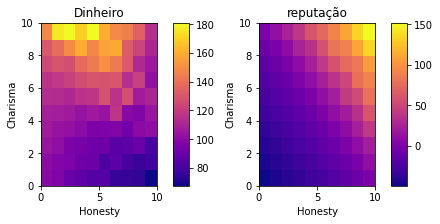

tempo de analise1363.2509291172028


In [ ]:
#barabasi - problema do prisioneiro - codigo moral de ordem 1:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=-1,P=0,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1)

tempo da primeira simulaçao: 22.940473318099976


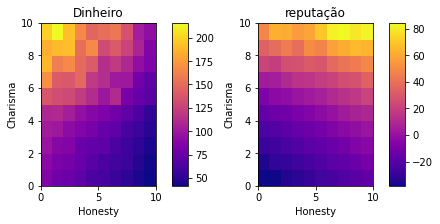

tempo de analise1376.077031135559


In [ ]:
#analise_grande(numero_de_simulaçoes,n,t, tipo_de_simulaçao = 1,R=2,T=3,S=-1,P=0,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1):
#barabasi - problema do prisioneiro - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=-1,P=0,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1)

tempo da primeira simulaçao: 22.23908233642578


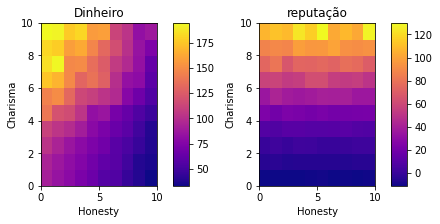

tempo de analise1326.8990154266357


In [ ]:
#este é o código moral de ordem 2 em que interagir com bons é bem visto e interagir com maus é mal bem visto
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=-1,P=0,CM1 = 1, CM2 = 1,CM3 = -1,CM4 = -1)

tempo da primeira simulaçao: 22.05689239501953


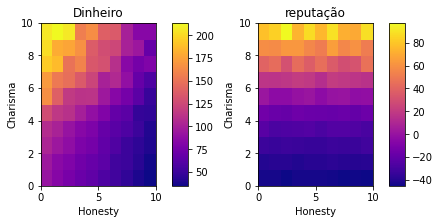

tempo de analise1359.3716547489166


In [ ]:
#este é o código moral de ordem 2 em que interagir com mauss é bem visto e interagir com bons é mal bem visto
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=-1,P=0,CM1 = -1, CM2 = -1,CM3 = 1,CM4 = 1)

tempo da primeira simulaçao: 22.407026529312134


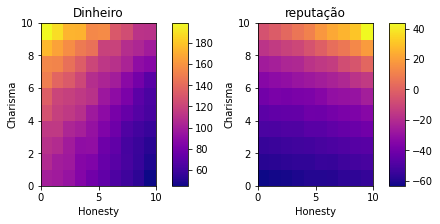

tempo de analise1355.2961225509644


In [ ]:
#este é o código moral de ordem 2 em que cooperar com bons é bem visto e e o resto é tudo mal visto
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=-1,P=0,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = -1)

#Stag Hunt

tempo da primeira simulaçao: 22.469647645950317


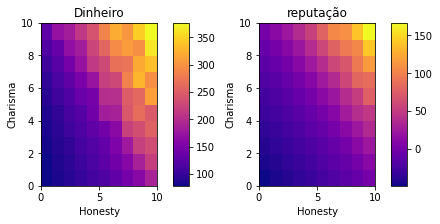

tempo de analise1359.408486366272


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 1:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1)

carisma_media: 0.5025233725800476
honestidade_media: 0.5036413448901187
tempo da primeira simulaçao: 21.154424905776978


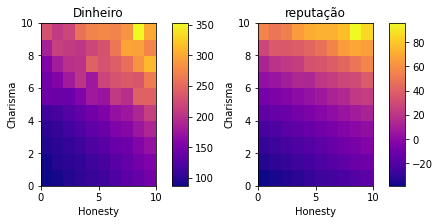

tempo de analise1281.7259526252747


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1)

carisma_media: 0.5025578219006447
honestidade_media: 0.4904307953295147
tempo da primeira simulaçao: 19.87561011314392


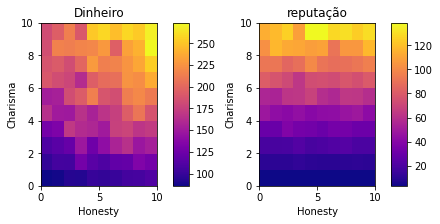

tempo de analise1217.2114753723145


In [ ]:
##barabasi - stag or hare - código moral de ordem 2 em que interagir com bons é bem visto e interagir com maus é mal bem visto
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = 1,CM3 = -1,CM4 = -1)

carisma_media: 0.499718963320809
honestidade_media: 0.5036154879074178
tempo da primeira simulaçao: 21.55655527114868


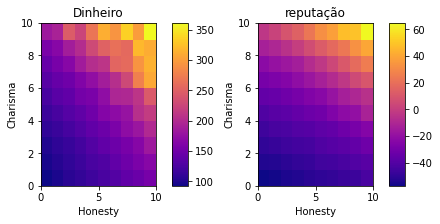

tempo de analise1321.2668273448944


In [ ]:
##barabasi - stag or hare - código moral de ordem 2 em que cooperar com bons é bem visto e e o resto é tudo mal visto
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = -1)

#Snowdrift

In [ ]:
    #snowdrift/chicken game:
    #R,T,S,P = (2,3,1,0)

carisma_media: 0.4942464888601714
honestidade_media: 0.5042444535171005
tempo da primeira simulaçao: 21.73019528388977


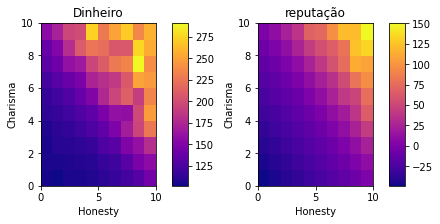

tempo de analise1345.4781031608582


In [ ]:
#barabasi - snowdrift/chicken game - codigo moral de ordem 1:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=1,P=0,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1)

carisma_media: 0.4946080738994131
honestidade_media: 0.5032299855940708
tempo da primeira simulaçao: 21.585503578186035


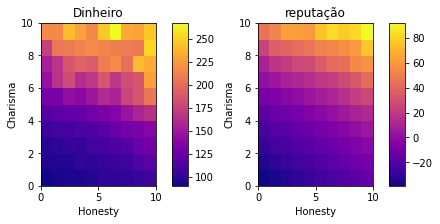

tempo de analise1377.3295907974243


In [ ]:
#barabasi - snowdrift/chicken game - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=1,P=0,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1)

carisma_media: 0.4999446985073528
honestidade_media: 0.5054487951358589
tempo da primeira simulaçao: 20.02969789505005


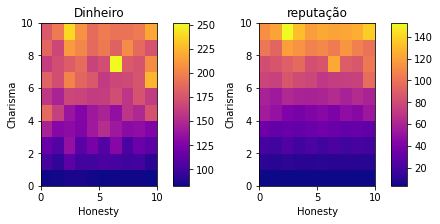

tempo de analise1223.1536002159119


In [ ]:
#barabasi - snowdrift/chicken game  - código moral de ordem 2 em que interagir com bons é bem visto e interagir com maus é mal bem visto
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=1,P=0,CM1 = 1, CM2 = 1,CM3 = -1,CM4 = -1)

carisma_media: 0.5024339477928136
honestidade_media: 0.4978323465263571
tempo da primeira simulaçao: 21.618303298950195


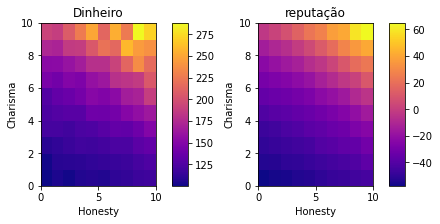

tempo de analise1328.531144618988


In [ ]:
#barabasi - snowdrift/chicken game  - código moral de ordem 2 em que cooperar com bons é bem visto e e o resto é tudo mal visto
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=1,P=0,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = -1)

#Heaven

In [ ]:
    #heaven
    #R,T,S,P = (3,2,0,-1)

carisma_media: 0.5011808828652545
honestidade_media: 0.49512108349521733
tempo da primeira simulaçao: 22.522810459136963


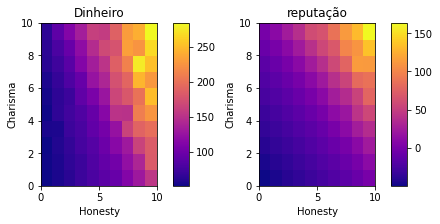

tempo de analise1344.4325995445251


In [ ]:
#barabasi - heaven - codigo moral de ordem 1:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=2,S=0,P=-1,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1)

carisma_media: 0.5021076147196044
honestidade_media: 0.5032975066340953
tempo da primeira simulaçao: 22.362759113311768


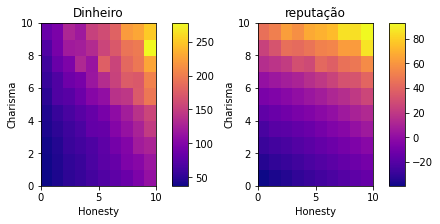

tempo de analise1327.4797313213348


In [ ]:
#barabasi - snowdrift/chicken game - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=2,S=0,P=-1,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1)

carisma_media: 0.502444785441085
honestidade_media: 0.5016474334622304
tempo da primeira simulaçao: 19.980271100997925


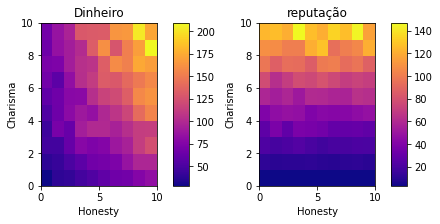

tempo de analise1230.052387714386


In [ ]:
#barabasi - snowdrift/chicken game  - código moral de ordem 2 em que interagir com bons é bem visto e interagir com maus é mal bem visto
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=2,S=0,P=-1,CM1 = 1, CM2 = 1,CM3 = -1,CM4 = -1)

carisma_media: 0.5087282256584147
honestidade_media: 0.49469502574921415
tempo da primeira simulaçao: 21.81489062309265


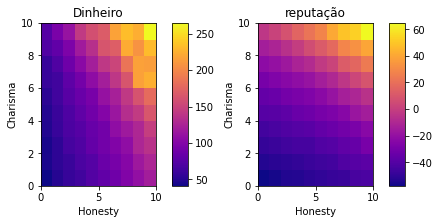

tempo de analise1316.82776927948


In [ ]:
#barabasi - snowdrift/chicken game  - código moral de ordem 2 em que cooperar com bons é bem visto e e o resto é tudo mal visto
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=2,S=0,P=-1,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = -1)

#Changing the distribution of honesty:

carisma_media: 0.5125158365757654
honestidade_media: 0.6531412003879026
tempo da primeira simulaçao: 20.375943660736084


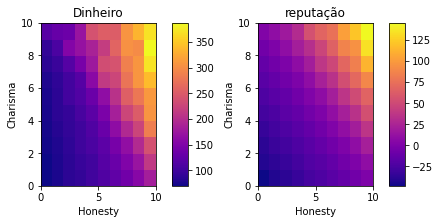

tempo de analise1273.0839610099792


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 1:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1,med_honestidade=0.2)

carisma_media: 0.5002511670052019
honestidade_media: 0.3489836366012288
tempo da primeira simulaçao: 21.307303190231323


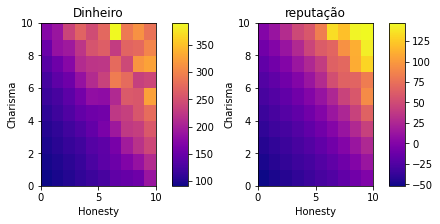

tempo de analise1311.8477761745453


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 1:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = 1,CM4 = -1,med_honestidade=0.8)

carisma_media: 0.5001025879163589
honestidade_media: 0.6541698402070573
tempo da primeira simulaçao: 22.170112371444702


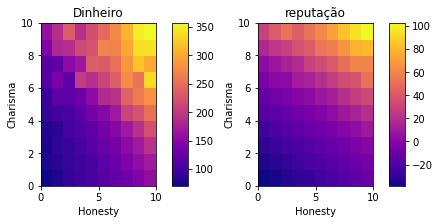

tempo de analise1311.2164947986603


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.2)

carisma_media: 0.5063556489990714
honestidade_media: 0.35062287717115304
tempo da primeira simulaçao: 21.8769748210907


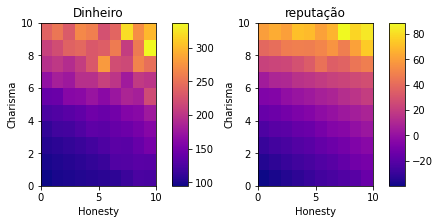

tempo de analise1394.2127919197083


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.8)

carisma_media: 0.5025527827617268
honestidade_media: 0.7255890501329518
tempo da primeira simulaçao: 20.95001983642578


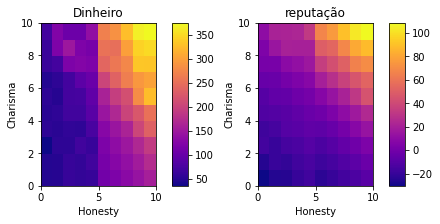

tempo de analise1252.4125628471375


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.05)

carisma_media: 0.5028282997561426
honestidade_media: 0.27296003461987817
tempo da primeira simulaçao: 20.696298360824585


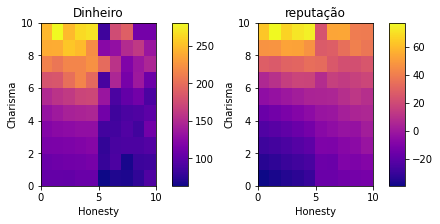

tempo de analise1274.0448052883148


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.95)

carisma_media: 0.5011899695764885
honestidade_media: 0.2785700808548545
tempo da primeira simulaçao: 20.822082042694092


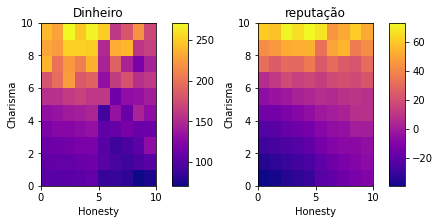

tempo de analise1272.618141412735


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.93)

carisma_media: 0.5015866646508993
honestidade_media: 0.30221489189345613
tempo da primeira simulaçao: 20.82262635231018


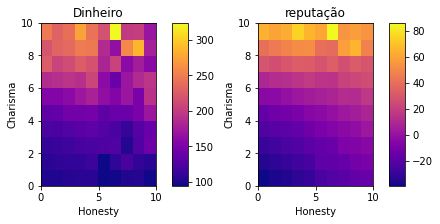

tempo de analise1268.0451593399048


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.9)

carisma_media: 0.49692539214266424
honestidade_media: 0.3193944520368673
tempo da primeira simulaçao: 20.728006839752197


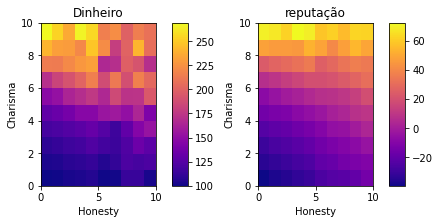

tempo de analise1263.5166478157043


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.87)

carisma_media: 0.5009493308133238
honestidade_media: 0.32347130549235925
tempo da primeira simulaçao: 20.565171718597412


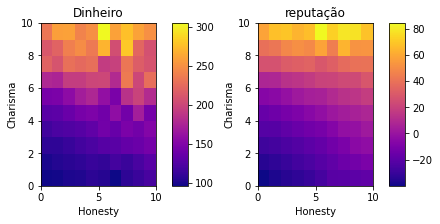

tempo de analise1271.7363305091858


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.85)

carisma_media: 0.5028822233663313
honestidade_media: 0.2737010707002751
tempo da primeira simulaçao: 21.122227430343628


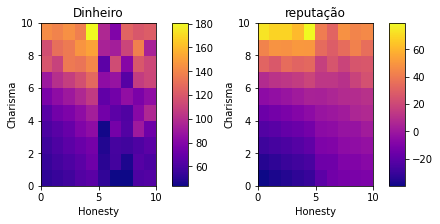

tempo de analise1265.2673540115356


In [ ]:
#barabasi - snowdrift/chicken game - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=1,P=0,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.95)

carisma_media: 0.5011450708386207
honestidade_media: 0.7241093625400753
tempo da primeira simulaçao: 20.88244891166687


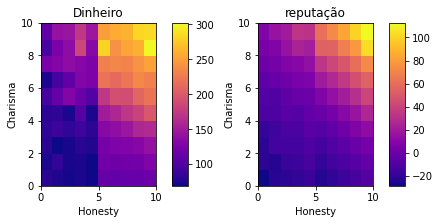

tempo de analise1271.5990047454834


In [ ]:
#barabasi - snowdrift/chicken game - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=2,T=3,S=1,P=0,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.05)

# Impact of reputation

carisma_media: 0.5011755723546867
honestidade_media: 0.7261390032392248
tempo da primeira simulaçao: 20.861196279525757


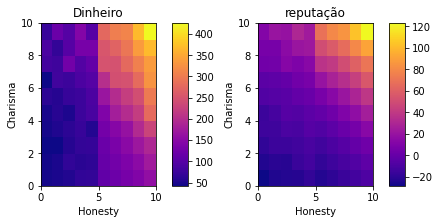

tempo de analise1282.951550245285


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.05)

carisma_media: 0.5011188374139057
honestidade_media: 0.72239388794573
tempo da primeira simulaçao: 18.590096950531006


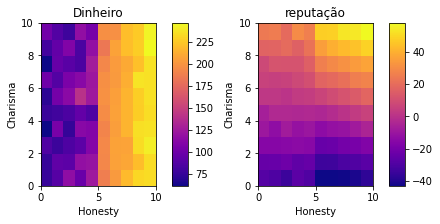

tempo de analise1137.3941452503204


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.05,cena_da_reputacao = False)

carisma_media: 0.4966297933559081
honestidade_media: 0.6997716676568093
tempo da primeira simulaçao: 21.618194580078125


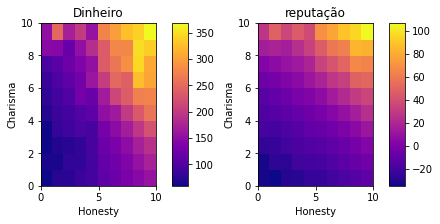

tempo de analise1317.861121892929


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.1)

carisma_media: 0.5086612527965738
honestidade_media: 0.6970752713529993
tempo da primeira simulaçao: 18.68326163291931


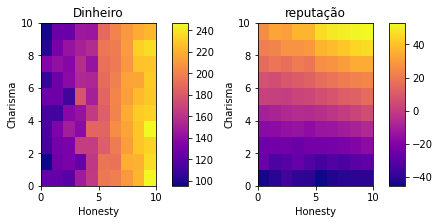

tempo de analise1142.088190793991


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.1,cena_da_reputacao = False)

carisma_media: 0.49315344014058055
honestidade_media: 0.6773716655254386
tempo da primeira simulaçao: 21.818692922592163


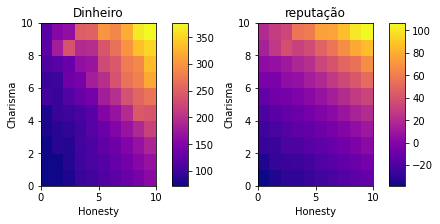

tempo de analise1359.2754032611847


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.15)

carisma_media: 0.5021695731477829
honestidade_media: 0.6722521714152173
tempo da primeira simulaçao: 18.651177406311035


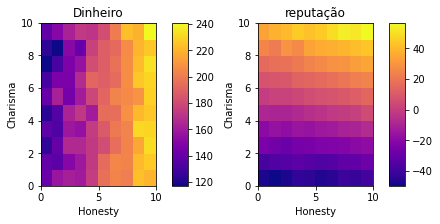

tempo de analise1147.9058649539948


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.15,cena_da_reputacao = False)

carisma_media: 0.49977661439089655
honestidade_media: 0.654037382068345
tempo da primeira simulaçao: 21.855307579040527


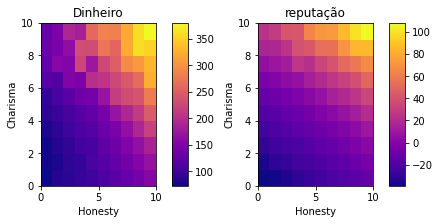

tempo de analise1323.3841960430145


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.2)

carisma_media: 0.5043725039667393
honestidade_media: 0.6542070965073765
tempo da primeira simulaçao: 19.059062957763672


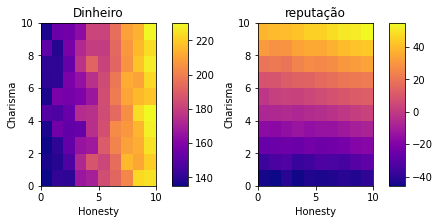

tempo de analise1175.0541017055511


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.2,cena_da_reputacao = False)

carisma_media: 0.5004936097563071
honestidade_media: 0.4987990952605463
tempo da primeira simulaçao: 21.78821110725403


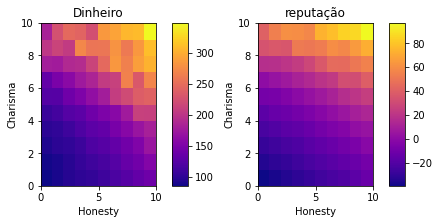

tempo de analise1337.7139229774475


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.5)

carisma_media: 0.5026555798307863
honestidade_media: 0.5007661638004826
tempo da primeira simulaçao: 19.751209020614624


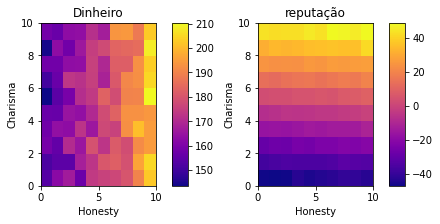

tempo de analise1169.0311043262482


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.5,cena_da_reputacao = False)

carisma_media: 0.5041498894872762
honestidade_media: 0.3975691001622082
tempo da primeira simulaçao: 22.25318741798401


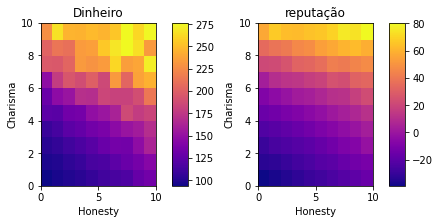

tempo de analise1342.6209399700165


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.7)

carisma_media: 0.4991808666083258
honestidade_media: 0.4005771576850309
tempo da primeira simulaçao: 19.085741996765137


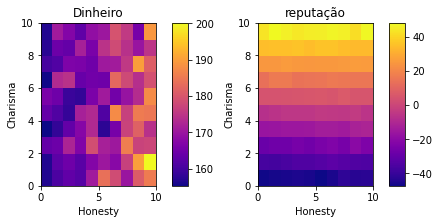

tempo de analise1167.7490448951721


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.7,cena_da_reputacao = False)

carisma_media: 0.49472616783469503
honestidade_media: 0.3814172180854647
tempo da primeira simulaçao: 22.217963933944702


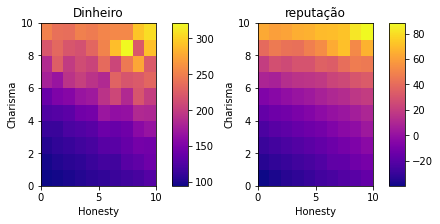

tempo de analise1350.0633454322815


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.75)

carisma_media: 0.49452348285255915
honestidade_media: 0.38157438770961316
tempo da primeira simulaçao: 18.60040545463562


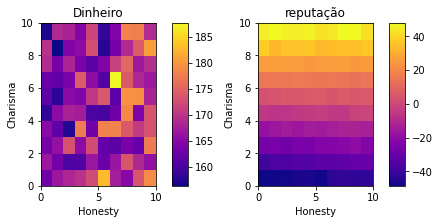

tempo de analise1166.3060729503632


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.75,cena_da_reputacao = False)

carisma_media: 0.4994827028303223
honestidade_media: 0.3483438393861925
tempo da primeira simulaçao: 22.92663812637329


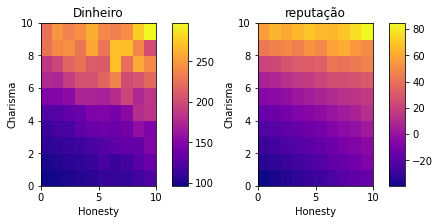

tempo de analise1346.7481491565704


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.8)

carisma_media: 0.49768462055901586
honestidade_media: 0.3429052896096752
tempo da primeira simulaçao: 18.913410425186157


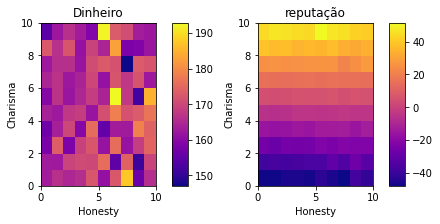

tempo de analise1173.9479496479034


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.8,cena_da_reputacao = False)

carisma_media: 0.5025862605589315
honestidade_media: 0.3247448529031309
tempo da primeira simulaçao: 22.08847975730896


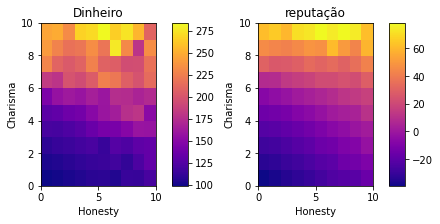

tempo de analise1342.4558143615723


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.85)

carisma_media: 0.4975319647269688
honestidade_media: 0.3179802985866366
tempo da primeira simulaçao: 18.584253072738647


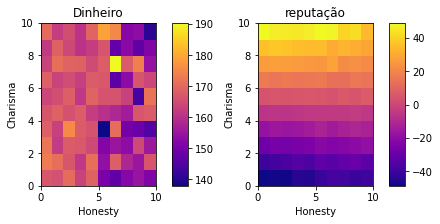

tempo de analise1161.5781614780426


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.85,cena_da_reputacao = False)

carisma_media: 0.4988258420594206
honestidade_media: 0.316166262069109
tempo da primeira simulaçao: 22.103856086730957


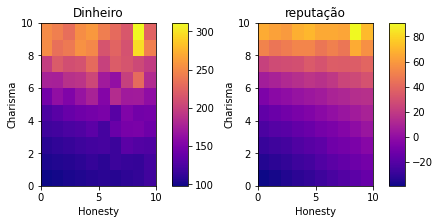

tempo de analise1349.303718805313


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.86)

carisma_media: 0.5026905815346429
honestidade_media: 0.31896577705128126
tempo da primeira simulaçao: 18.788519144058228


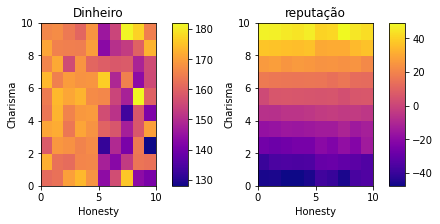

tempo de analise1148.467145204544


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.86,cena_da_reputacao = False)

carisma_media: 0.5027790830163896
honestidade_media: 0.32711439845647067
tempo da primeira simulaçao: 29.102282524108887


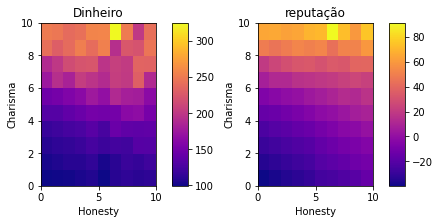

tempo de analise2484.184483528137


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(100,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.86)

carisma_media: 0.5061410919967472
honestidade_media: 0.32181655071467535
tempo da primeira simulaçao: 20.84298324584961


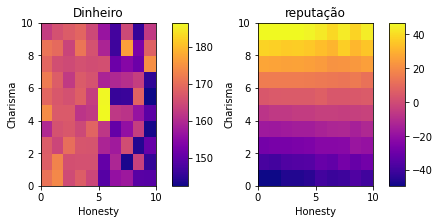

tempo de analise2193.029773235321


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(100,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.86,cena_da_reputacao = False)

carisma_media: 0.5066777720217485
honestidade_media: 0.315192331804132
tempo da primeira simulaçao: 22.09074640274048


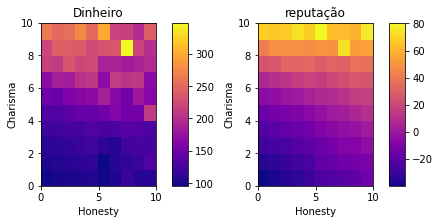

tempo de analise1340.4281539916992


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.88)

carisma_media: 0.5037349855630611
honestidade_media: 0.3118447897437504
tempo da primeira simulaçao: 19.00993824005127


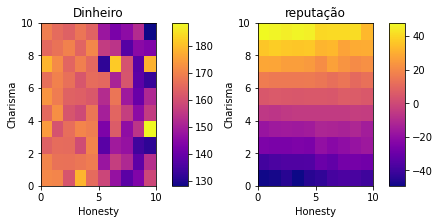

tempo de analise1172.2792422771454


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.88,cena_da_reputacao = False)

carisma_media: 0.49477111979208643
honestidade_media: 0.3166703286319073
tempo da primeira simulaçao: 23.822163343429565


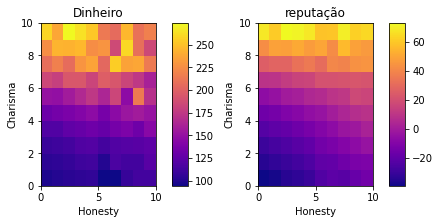

tempo de analise2497.213263988495


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(100,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.88)

carisma_media: 0.4973478634876041
honestidade_media: 0.31598852924995974
tempo da primeira simulaçao: 20.585956573486328


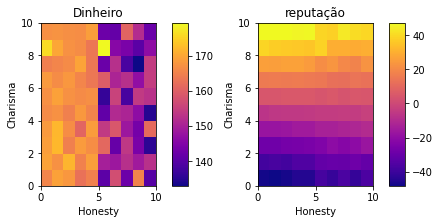

tempo de analise2161.2770857810974


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(100,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.88,cena_da_reputacao = False)

carisma_media: 0.4963173246978179
honestidade_media: 0.294287901556121
tempo da primeira simulaçao: 21.9053795337677


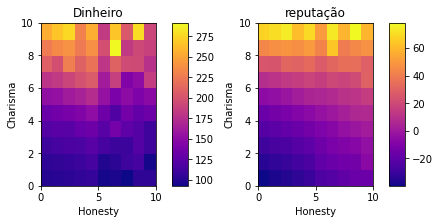

tempo de analise1345.490582704544


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.9)

carisma_media: 0.4978537264998268
honestidade_media: 0.2982427118806939
tempo da primeira simulaçao: 18.741655826568604


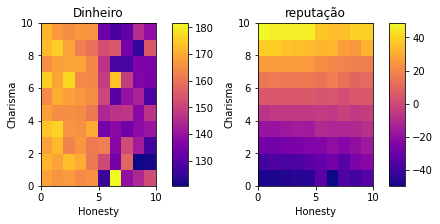

tempo de analise1142.5615634918213


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.9,cena_da_reputacao = False)

carisma_media: 0.496453600704077
honestidade_media: 0.27557915508683295
tempo da primeira simulaçao: 22.356311559677124


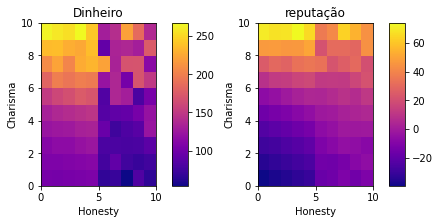

tempo de analise1322.4040460586548


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.95)

carisma_media: 0.49725519506995985
honestidade_media: 0.2754705236254159
tempo da primeira simulaçao: 18.532880544662476


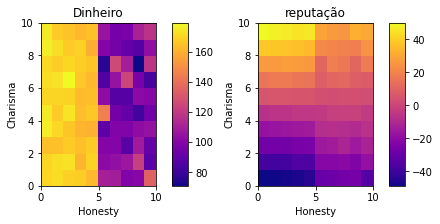

tempo de analise1142.703038930893


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.95,cena_da_reputacao = False)

# Hubs

carisma_media: 0.5054367471168703
honestidade_media: 0.5030814160768428
tempo da primeira simulaçao: 20.552770614624023
Dinheiro médio : 180.929
Percentagem interacoes do no maior grau : 4.1515


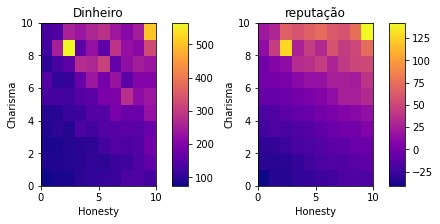

tempo de analise41.397754430770874


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(2,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1)

carisma_media: 0.5031939948240338
honestidade_media: 0.5003250233857116
tempo da primeira simulaçao: 20.59381365776062
Dinheiro médio : 180.1076
Percentagem interacoes do no maior grau : 3.9865000000000004


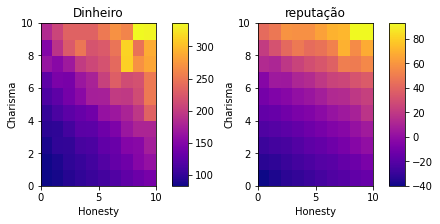

tempo de analise411.52012372016907


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1)

carisma_media: 0.5017271444373659
honestidade_media: 0.5005968533045919
tempo da primeira simulaçao: 20.978502988815308
Dinheiro médio : 177.4388
Percentagem interacoes do no maior grau : 0.09104999999999999


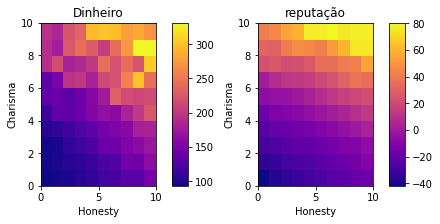

tempo de analise419.3132758140564


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=0,nova_honestidade=0,nova_reputacao=-1)

carisma_media: 0.4978572468007377
honestidade_media: 0.5036690310077736
tempo da primeira simulaçao: 23.34667730331421
Dinheiro médio : 179.723
Percentagem interacoes do no maior grau : 4.031250000000002


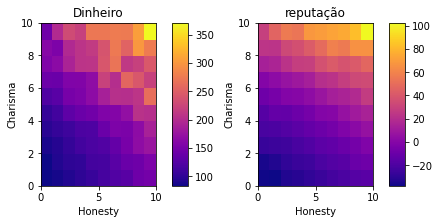

tempo de analise427.37063241004944


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=1,nova_honestidade=1,nova_reputacao=0)

carisma_media: 0.49939818587351786
honestidade_media: 0.49562611918418703
tempo da primeira simulaçao: 20.954782724380493
Dinheiro médio : 179.0291
Percentagem interacoes do no maior grau : 2.2889499999999994


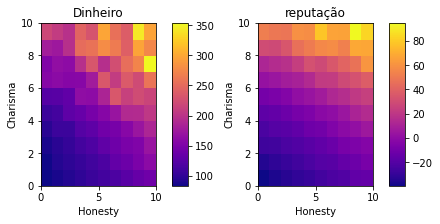

tempo de analise417.2206676006317


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=1/2,nova_honestidade=1,nova_reputacao=0)

carisma_media: 0.49764244198345375
honestidade_media: 0.4996635697443684
tempo da primeira simulaçao: 21.116223096847534
Dinheiro médio : 177.83759999999998
Percentagem interacoes do no maior grau : 0.1401


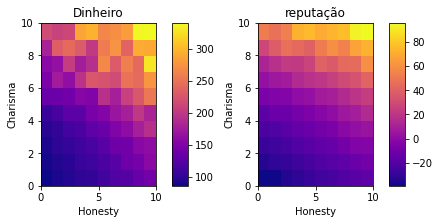

tempo de analise433.7747395038605


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=0,nova_honestidade=1,nova_reputacao=0)

carisma_media: 0.5053013872118884
honestidade_media: 0.5008105241038197
tempo da primeira simulaçao: 21.934930086135864
Dinheiro médio : 177.28969999999998
Percentagem interacoes do no maior grau : 4.033399999999999


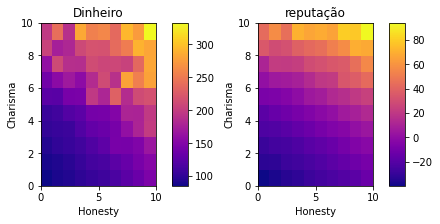

tempo de analise433.1075167655945


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=1,nova_honestidade=1/2,nova_reputacao=0)

carisma_media: 0.4984001888940654
honestidade_media: 0.5004679047426414
tempo da primeira simulaçao: 21.330923795700073
Dinheiro médio : 178.1144
Percentagem interacoes do no maior grau : 0.7881000000000001


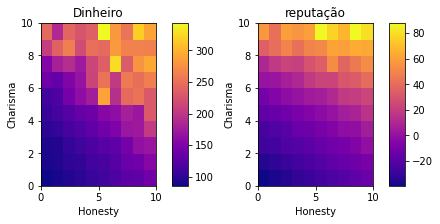

tempo de analise423.112918138504


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=1/2,nova_honestidade=1/2,nova_reputacao=0)

carisma_media: 0.49676439752960444
honestidade_media: 0.5026074859025663
tempo da primeira simulaçao: 23.631187438964844
Dinheiro médio : 177.33030000000002
Percentagem interacoes do no maior grau : 0.10500000000000001


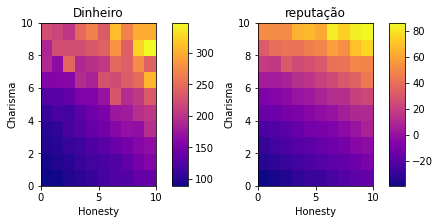

tempo de analise443.36886191368103


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=0,nova_honestidade=1/2,nova_reputacao=0)

In [ ]:
17600/179.7

97.94101279910963

carisma_media: 0.49687925501115926
honestidade_media: 0.5082062006427825
tempo da primeira simulaçao: 21.80246090888977
Dinheiro médio : 176.09280000000004
Percentagem interacoes do no maior grau : 3.6887000000000008


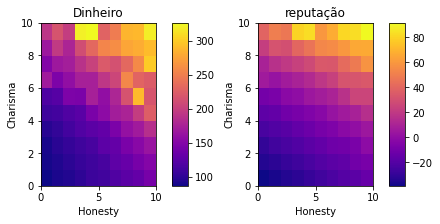

tempo de analise424.462206363678


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=1,nova_honestidade=0,nova_reputacao=0)

carisma_media: 0.499851513337338
honestidade_media: 0.5002894055709666
tempo da primeira simulaçao: 21.31972074508667
Dinheiro médio : 177.68840000000006
Percentagem interacoes do no maior grau : 0.37349999999999994


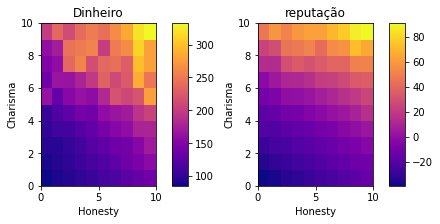

tempo de analise426.853777885437


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=1/2,nova_honestidade=0,nova_reputacao=0)

carisma_media: 0.5071483168977748
honestidade_media: 0.49067821722676147
tempo da primeira simulaçao: 21.392049074172974
Dinheiro médio : 177.4416
Percentagem interacoes do no maior grau : 0.09140000000000001


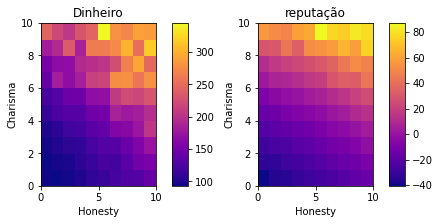

tempo de analise433.99058628082275


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hub(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=0,nova_honestidade=0,nova_reputacao=0)

#Hubs Alpha

carisma_media: 0.5043765589631785
honestidade_media: 0.49959027092254976
tempo da primeira simulaçao: 20.748008489608765
Dinheiro médio : 183.20909999999998
Percentagem interacoes do no maior grau : 3.0175058928571437
Numero medio de hubs considerado por simulacao : 3.75


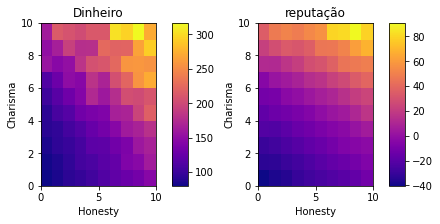

tempo de analise427.53816652297974


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hubs(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,alpha=0.7)

carisma_media: 0.4964031232585558
honestidade_media: 0.5011126241444095
tempo da primeira simulaçao: 21.467224597930908
Dinheiro médio : 177.10020000000003
Percentagem interacoes do no maior grau : 0.09587166666666667
Numero medio de hubs considerado por simulacao : 3.2


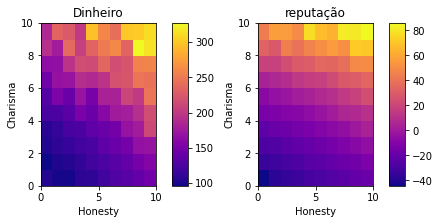

tempo de analise427.8039712905884


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hubs(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=0,nova_honestidade=0,nova_reputacao=0,alpha=0.7)

carisma_media: 0.4943751359214613
honestidade_media: 0.5052149468866668
tempo da primeira simulaçao: 21.475609064102173
Dinheiro médio : 176.9529
Percentagem interacoes do no maior grau : 0.10770751984126983
Numero medio de hubs considerado por simulacao : 5.2


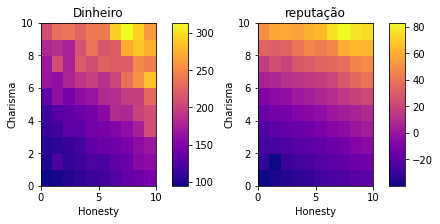

tempo de analise427.8517701625824


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hubs(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=0.1,nova_honestidade=0.1,nova_reputacao=0,alpha=0.5)

carisma_media: 0.4965077612277773
honestidade_media: 0.4990702684745237
tempo da primeira simulaçao: 21.66360640525818
Dinheiro médio : 174.0914
Percentagem interacoes do no maior grau : 3.436793333333333
Numero medio de hubs considerado por simulacao : 2.8


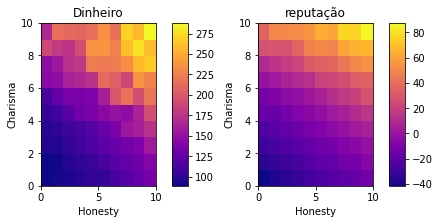

tempo de analise431.6485559940338


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_hubs(20,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,novo_carisma=1,nova_honestidade=0,nova_reputacao=0,alpha=0.7)

carisma_media: 0.5040183727584768
honestidade_media: 0.3584894815548817
tempo da primeira simulaçao: 21.751380681991577


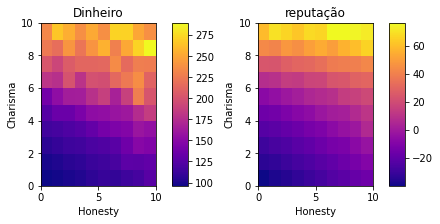

tempo de analise1303.9575653076172


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.8)

carisma_media: 0.48882709862408597
honestidade_media: 0.345360807648231
tempo da primeira simulaçao: 18.44374132156372


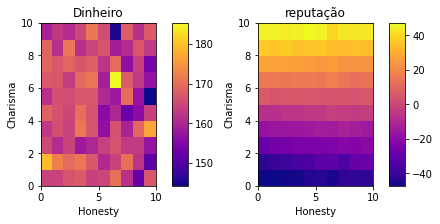

tempo de analise1141.9692499637604


In [ ]:
#barabasi - stag or hare - codigo moral de ordem 2 onde é bom cooperar com bons e nao cooperar com maus:
analise_grande(60,1000,50, tipo_de_simulaçao = 1,R=3,T=1,S=1,P=2,CM1 = 1, CM2 = -1,CM3 = -1,CM4 = 1,med_honestidade=0.82,cena_da_reputacao = False)